In [1]:
# Import Libraries
import os,sys,warnings
if not sys.warnoptions:    
    warnings.simplefilter('ignore')
    
import numpy as np
from numpy.linalg import pinv,inv
import pandas as pd
# !pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(style='whitegrid')
%matplotlib inline
# !pip install geoplot
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin,ClassifierMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
# !pip install mllibs
# from pyspark.bl_regressor import BR
pi = 4.0*np.arctan(1.0)

color1 = 'darkviolet'
color2 = 'indigo'

In [2]:
df = pd.read_csv(r'D:\Data\Chetan\housing.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [3]:
def eliminate_outliers(table):
    a=table.select_dtypes(include=[np.number]).columns.tolist()
    for i in a:
        q1 = table[i].quantile(0.25)
        q3 = table[i].quantile(0.75)
        
        iqr = q3-q1 #Interquartile range

        upper_limit = q3+1.5*iqr 
        lower_limit = q1-1.5*iqr
    
        #print("Upper limit = ",upper_limit)
        #print("Lower limit = ",lower_limit)

        table[i]=np.where(table[i] > upper_limit,upper_limit,table[i]) # upper limit
        table[i]=np.where(table[i] < lower_limit,lower_limit,table[i]) # lower limit
    

<Axes: >

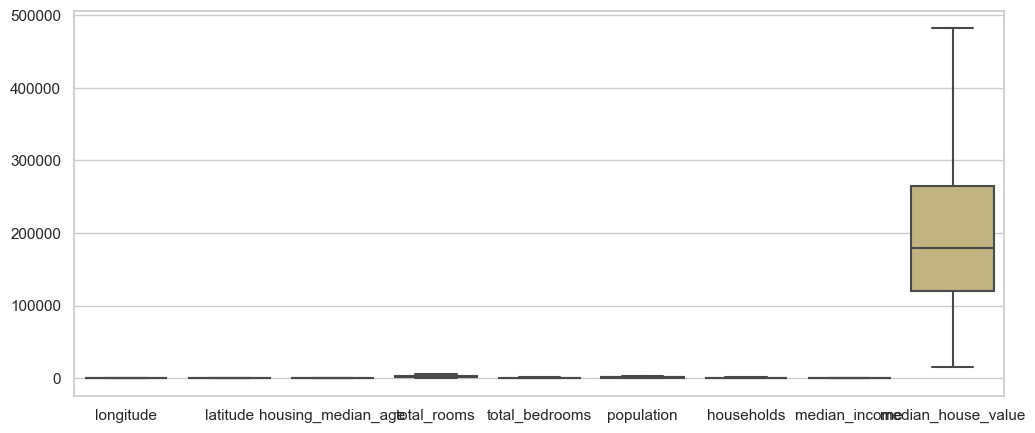

In [5]:
eliminate_outliers(df)

fig, axarr  = plt.subplots(figsize=(12,5))
sns.boxplot(data=df)

In [7]:
x=df.drop('median_house_value', axis = 1)
y=df[['median_house_value']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(x,y,train_size=0.8,random_state=55)

In [8]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
7620,-118.25,33.84,19.0,1731.0,420.0,1032.0,364.0,3.8125,<1H OCEAN
7073,-118.02,33.95,35.0,2085.0,400.0,1112.0,391.0,3.4886,<1H OCEAN
1803,-122.35,37.91,4.0,2851.0,798.0,1285.0,712.0,4.2895,NEAR BAY
9062,-118.15,34.69,32.0,1300.0,234.0,712.0,249.0,3.2500,INLAND
11396,-117.97,33.73,19.0,4154.0,560.0,2130.0,589.0,7.2845,<1H OCEAN


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_cols = x.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = x.select_dtypes(include=[np.number]).columns.tolist()


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

In [20]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_test)

# Evaluate the model
score = mean_absolute_error(y_test, preds)
print('MAE:', score)

MAE: 31765.28109859496


In [21]:
from sklearn import metrics
print(metrics.r2_score(y_test, preds))

0.8107461488745683


In [16]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [17]:
y_train.columns

Index(['median_house_value'], dtype='object')